# Sklearn
Notebook pensando para facilitar e agiliar o treinamento de Machine Learning, sendo necessário, em grande parte das vezes, somente alterar o caminho do dataset e o tipo (classificador ou regressão).

In [1]:
import warnings
warnings.filterwarnings('ignore')

import copy
import json
import math
import time
import pickle

import pandas as pd
from sklearn.preprocessing import LabelEncoder

## Preparar Dataset

In [2]:
def preprocess_data(df, target_cols, max_unique_values=10, window_size=1):
    """
    Preprocess dataset, converting string columns to number and identifying numeric, categorical, and date columns.
    Adds a window of historical rows to the data.

    Args:
        df (DataFrame): DataFrame with data to analyze.
        target_cols (list): All target columns to not add in numeric, categorical, or date feature lists.
        max_unique_values (int): Maximum number of unique values to consider a numeric column as categorical.
        window_size (int): Number of previous rows to include for each row.

    Returns:
        df_copy (DataFrame): Processed DataFrame with transformations applied.
        num_col_names (list): List of numeric feature column names.
        cat_col_names (list): List of categorical feature column names.
        date_col_names (list): List of date feature column names.
        mappings (dict): Mapping of original categorical values (or target columns) to transformed numeric values.
    """
    # Create a copy so as not to alter the original DataFrame
    df_copy = df.copy()

    # Remove lines with null values
    df_copy = df_copy.dropna()
    
    # Identify categorical and numeric columns
    cat_col_names = df_copy.select_dtypes(include=['object', 'category']).columns.tolist()
    num_col_names = df_copy.select_dtypes(include=['number']).columns.tolist()
    date_col_names = []

    # Identify columns that are dates
    for col in df.columns:
        if df[col].dtype in ['object', 'string']:  # Only check object/string columns
            try:
                # Attempt to convert the column to datetime
                pd.to_datetime(df[col], errors='raise')
                if col not in target_cols:  # Avoid considering target columns as date columns
                    date_col_names.append(col)
            except (ValueError, TypeError):
                pass

    # Identify numeric columns that are categorical
    potential_categorical = []
    for col in num_col_names:
        if col not in target_cols and df_copy[col].nunique() <= max_unique_values:
            potential_categorical.append(col)

    cat_col_names += potential_categorical

    # Remove target columns from the lists
    num_col_names = [col for col in num_col_names if col not in potential_categorical + target_cols]
    cat_col_names = [col for col in cat_col_names if col not in target_cols]
    
    mappings = {}
    label_encoders = {}

    # Convert string columns to category and create a mapping (old value -> new value)
    for col in cat_col_names + target_cols:
        if df_copy[col].dtype not in ['int64', 'float64']:
            le = LabelEncoder()
            df_copy[col] = le.fit_transform(df_copy[col])
            mappings[col] = dict(zip(le.classes_, le.transform(le.classes_)))
            label_encoders[col] = le
            # Convert values to int (otherwise will raise error if save as json)
            for key, value in mappings[col].items():
                mappings[col][key] = int(value)
        #else:
        #    mappings[col] = {int(val): int(val) for val in df_copy[col].unique()}

    # Add historical data based on window_size
    if window_size > 1:
        historical_features = []
        for i in range(window_size - 1, 0, -1):  # Criar features lag, do mais antigo ao mais recente
            shifted = df_copy.drop(columns=target_cols, errors='ignore').shift(i).add_suffix(f'_lag_{i}')
            historical_features.append(shifted)
        
        # Concatenate the lags to the left and keep the current values
        df_copy = pd.concat(historical_features + [df_copy], axis=1)
    
        # Remove NaNs columns created by shifts
        df_copy = df_copy.dropna()
    
        # Add lags
        num_col_lags = [f'{col}_lag_{i}' for i in range(window_size - 1, 0, -1) for col in num_col_names]
        cat_col_lags = [f'{col}_lag_{i}' for i in range(window_size - 1, 0, -1) for col in cat_col_names]
        date_col_lags = [f'{col}_lag_{i}' for i in range(window_size - 1, 0, -1) for col in date_col_names]
        mappings_lags = {}
        for col, value in mappings.items():
            for i in range(window_size - 1, 0, -1):
                mappings_lags[f'{col}_lag_{i}'] = value
    
        # Update main columns + lags columns
        num_col_names = num_col_lags + num_col_names
        cat_col_names = cat_col_lags + cat_col_names
        date_col_names = date_col_lags + date_col_names
        mappings = {**mappings_lags, **mappings}
    
    return df_copy, num_col_names, cat_col_names, date_col_names, mappings

In [3]:
df = pd.read_csv('dataset/synthetic_dataset_cat_1000.csv')
model_type = 'classifier'  # classifier or regressor
window_size = 1
df

,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,target
0,40.943028,D,95.950177,146.784815,6.588798,-0.017978,0.95,0.888880,type_3
1,42.237444,B,33.414015,71.588105,6.105207,-1.757895,0.90,1.388618,type_5
2,37.878264,A,31.199837,30.619985,5.692548,-0.288549,1.10,0.917035,type_2
3,87.171440,B,191.086484,319.806626,6.836627,0.265401,0.90,0.532572,type_5
4,27.933675,F,150.254689,40.762944,6.264615,-1.445865,0.85,0.535997,type_1
...,...,...,...,...,...,...,...,...,...
195,61.195129,B,114.621312,29.869450,5.870176,-1.495742,0.90,0.778481,type_2
196,14.833770,A,36.977376,317.971808,6.861369,-0.662053,1.10,0.322761,type_2
197,63.152322,E,141.728085,272.614971,5.046595,1.387005,1.20,0.237381,type_2
198,98.931559,B,154.505133,155.600579,5.557602,-0.089959,0.90,1.100501,type_5


In [4]:
target_cols = ['target']
# Aplicar o pré-processamento
df, num_col_names, cat_col_names, date_col_names, category_mappings = preprocess_data(df, target_cols, max_unique_values=10, window_size=window_size)
col_names_order = df.columns.tolist()

In [5]:
df

,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,target
0,40.943028,3,95.950177,146.784815,6.588798,-0.017978,0.95,0.888880,2
1,42.237444,1,33.414015,71.588105,6.105207,-1.757895,0.90,1.388618,4
2,37.878264,0,31.199837,30.619985,5.692548,-0.288549,1.10,0.917035,1
3,87.171440,1,191.086484,319.806626,6.836627,0.265401,0.90,0.532572,4
4,27.933675,5,150.254689,40.762944,6.264615,-1.445865,0.85,0.535997,0
...,...,...,...,...,...,...,...,...,...
195,61.195129,1,114.621312,29.869450,5.870176,-1.495742,0.90,0.778481,1
196,14.833770,0,36.977376,317.971808,6.861369,-0.662053,1.10,0.322761,1
197,63.152322,4,141.728085,272.614971,5.046595,1.387005,1.20,0.237381,1
198,98.931559,1,154.505133,155.600579,5.557602,-0.089959,0.90,1.100501,4


In [6]:
print(f'''col_names_order: {col_names_order}
num_col_names: {num_col_names}
cat_col_names: {cat_col_names}
date_col_names: {date_col_names}
target_cols: {target_cols}
category_mappings: {category_mappings}''')

col_names_order: ['feature_1', 'feature_2', 'feature_3', 'feature_4', 'feature_5', 'feature_6', 'feature_7', 'feature_8', 'target']
num_col_names: ['feature_1', 'feature_3', 'feature_4', 'feature_5', 'feature_6', 'feature_8']
cat_col_names: ['feature_2', 'feature_7']
date_col_names: []
target_cols: ['target']
category_mappings: {'feature_2': {'A': 0, 'B': 1, 'C': 2, 'D': 3, 'E': 4, 'F': 5}, 'target': {'type_1': 0, 'type_2': 1, 'type_3': 2, 'type_4': 3, 'type_5': 4}}


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 199 entries, 0 to 199
Data columns (total 9 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   feature_1  199 non-null    float64
 1   feature_2  199 non-null    int64  
 2   feature_3  199 non-null    float64
 3   feature_4  199 non-null    float64
 4   feature_5  199 non-null    float64
 5   feature_6  199 non-null    float64
 6   feature_7  199 non-null    float64
 7   feature_8  199 non-null    float64
 8   target     199 non-null    int64  
dtypes: float64(7), int64(2)
memory usage: 15.5 KB


In [8]:
if model_type == 'classifier':
    print(df[target_cols].value_counts())

target
0         40
1         40
2         40
3         40
4         39
Name: count, dtype: int64


### Dataset Split

In [9]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(df, random_state=42, test_size=0.3)

In [10]:
y_train = train[target_cols]
x_train = train.drop(target_cols, axis=1)

In [11]:
y_test = test[target_cols]
x_test = test.drop(target_cols, axis=1)

In [12]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

In [13]:
#from skelarn.preprocessing import MinMaxScaler

#scaler = preprocessing.MinMaxScaler()

In [14]:
x_train

,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8
141,4.370784,4,129.863756,33.030301,6.294606,-0.213289,1.20,0.815476
31,3.063916,3,33.897487,17.244720,6.399646,1.161585,0.95,0.841244
12,50.961416,2,97.127591,258.189565,6.621529,0.421408,1.05,0.981909
35,62.012349,5,187.236412,188.678727,6.838554,0.197655,0.85,0.800228
116,75.152697,1,50.334351,29.803158,6.803738,0.338283,0.90,0.988646
...,...,...,...,...,...,...,...,...
107,26.901083,4,127.958364,135.000095,6.810081,0.250144,1.20,0.693042
14,99.692857,1,90.115574,306.015141,6.183060,1.471663,0.90,0.825280
93,72.490543,3,43.363197,126.357698,6.880593,-0.076010,0.95,0.809276
180,52.153303,3,198.302270,53.664689,4.361762,-1.809451,0.95,0.153895


In [15]:
x_train[num_col_names] = scaler.fit_transform(x_train[num_col_names])
x_train = x_train.values.tolist()
x_train

[[-1.6390719314454374,
  4.0,
  0.24373358733057285,
  -1.240920023628208,
  0.08841874394774916,
  -0.051470981541365535,
  1.2,
  0.45628870481079997],
 [-1.6851210319448202,
  3.0,
  -1.4940116965919459,
  -1.3940374073826014,
  0.23137200570853375,
  1.296725164148002,
  0.95,
  0.5433991209240484],
 [0.002605934099511038,
  2.0,
  -0.3490488213312362,
  0.9430856760075131,
  0.5333452133773375,
  0.570910167096834,
  1.05,
  1.0189244799446933],
 [0.3919990921410464,
  5.0,
  1.2826305074935065,
  0.2688426312660103,
  0.8287053425592504,
  0.3514989931745535,
  0.85,
  0.40474207261700745],
 [0.8550153133844223,
  1.0,
  -1.1963749983508314,
  -1.2722227407018771,
  0.7813224394230988,
  0.4893980979332912,
  0.9,
  1.041698147816626],
 [1.0603385756862196,
  3.0,
  1.0364160668213105,
  -1.1221641186868059,
  0.8336056279682674,
  -0.9816692316405018,
  0.95,
  -0.5477784555235371],
 [-1.600009765374761,
  3.0,
  -0.15753690739079457,
  -0.31244056607997767,
  -0.402659565592537

In [16]:
x_test[num_col_names] = scaler.transform(x_test[num_col_names])
x_test = x_test.values.tolist()
x_test

[[1.539721113736791,
  1.0,
  -1.4297586629919297,
  -0.715173687046628,
  -1.3533065704797342,
  -1.3140041827680884,
  0.9,
  0.9587293306516864],
 [-1.0368180252252122,
  1.0,
  0.36311719562602784,
  -1.309679782744487,
  0.18287057124888223,
  -0.8420924164529009,
  0.9,
  -1.462517967649209],
 [-1.5725788888929624,
  3.0,
  0.3606362665449536,
  1.7849664788291413,
  -0.05816166411614554,
  0.15924915132356363,
  0.95,
  0.6898726387871306],
 [0.8874242249744806,
  5.0,
  1.2659014431509192,
  -0.9575722348718507,
  0.06698526351563568,
  0.5585793163102274,
  0.85,
  0.42929824639101405],
 [-0.11549452559868258,
  2.0,
  1.3882964986345436,
  -1.3220151521438714,
  -2.1600845895665333,
  0.13227173010630594,
  1.05,
  -1.2012799839817345],
 [-1.0735985333553548,
  1.0,
  -0.29258598085573995,
  0.2779856372774545,
  0.8509178468235408,
  0.2764432564861905,
  0.9,
  0.7191223945442085],
 [0.07227845387653746,
  1.0,
  -0.9410029368890123,
  -0.8275419409832606,
  0.1648785243297

### Variáveis de entrada mais importantes para as tomadas de decisão do modelo

#### Random Forest

In [17]:
if model_type == 'classifier':
    from sklearn.ensemble import RandomForestClassifier
    
    # Realizando Random Forest para identificar a relevância das variáveis.
    # Feature Extraction by Random Forest
    model = RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                           criterion='gini', max_depth=None, max_features=3, # nao sei o que eh este max_features
                           max_leaf_nodes=None, max_samples=None,
                           min_impurity_decrease=0.0,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=10,
                           n_jobs=None, oob_score=False, random_state=None,
                           verbose=0, warm_start=False)
    model.fit(x_train, y_train)
    
    feature_importances_val = model.feature_importances_
    pd.options.display.float_format = '{:.10f}'.format
    
    x_pd = pd.DataFrame(x_train, columns=col_names_order[:-1])
    feature_importances = pd.DataFrame(feature_importances_val,
                                       index = x_pd.columns,
                                       columns=['importance']).sort_values('importance', ascending = False)
    print(f'Accuracy: {model.score(x_test, y_test) * 100}')
    print(feature_importances)

Accuracy: 45.0
            importance
feature_3 0.2242632236
feature_4 0.1848555874
feature_8 0.1717752554
feature_1 0.1599245372
feature_6 0.1269456050
feature_5 0.0731077211
feature_2 0.0351100197
feature_7 0.0240180508


#### DecisionTree

Accuracy: 46.666666666666664
Confusion matrix: [[8 0 0 0 0]
 [4 8 6 6 2]
 [0 1 0 2 1]
 [0 1 6 8 1]
 [1 0 1 0 4]]
0-feature_1, Score: 0.06929457483146269
1-feature_2, Score: 0.0
2-feature_3, Score: 0.31187289459668793
3-feature_4, Score: 0.41889700958926107
4-feature_5, Score: 0.0
5-feature_6, Score: 0.0
6-feature_7, Score: 0.0
7-feature_8, Score: 0.19993552098258835


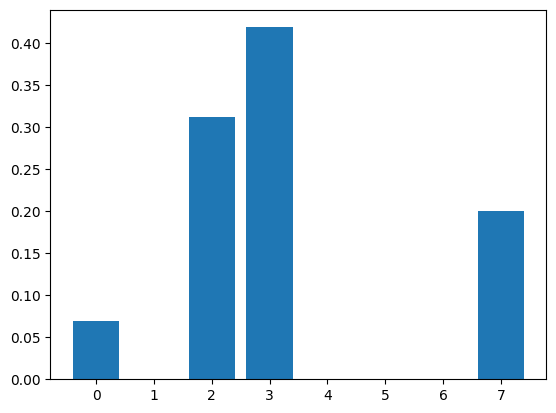

In [18]:
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error


if model_type == 'classifier':
    from sklearn.tree import DecisionTreeClassifier
    from sklearn.metrics import confusion_matrix
    model = DecisionTreeClassifier(max_depth=3)
else:
    from sklearn.tree import DecisionTreeRegressor
    model = DecisionTreeRegressor(max_depth=3)    

model.fit(x_train, y_train)

if model_type == 'classifier':
    print(f'Accuracy: {model.score(x_test, y_test) * 100}')
    print(f'Confusion matrix: {confusion_matrix(model.predict(x_test), y_test)}')
else:
    print(f'MSE: {mean_squared_error(model.predict(x_test), y_test)}')

importance = model.feature_importances_
for idx, score in enumerate(importance):
    print(f'{idx}-{df.keys()[idx]}, Score: {score}')

plt.bar([x for x in range(len(importance))], importance)
plt.show()

## Treinar diversos estimators disponíveis no Sklearn
https://scikit-learn.org/stable/supervised_learning.html

In [19]:
# https://scikit-learn.org/stable/modules/generated/sklearn.utils.discovery.all_estimators.html#sklearn.utils.discovery.all_estimators
from sklearn.utils import all_estimators

# classifier, regressor, cluster, transformer
estimators = all_estimators(type_filter=model_type)

all_estimators = {}
for name, estimator in estimators:
    try:
        print('Appending', name)
        est = estimator()
        all_estimators[name] = est
    except Exception as e:
        print(e)

Appending AdaBoostClassifier
Appending BaggingClassifier
Appending BernoulliNB
Appending CalibratedClassifierCV
Appending CategoricalNB
Appending ClassifierChain
_BaseChain.__init__() missing 1 required positional argument: 'base_estimator'
Appending ComplementNB
Appending DecisionTreeClassifier
Appending DummyClassifier
Appending ExtraTreeClassifier
Appending ExtraTreesClassifier
Appending GaussianNB
Appending GaussianProcessClassifier
Appending GradientBoostingClassifier
Appending HistGradientBoostingClassifier
Appending KNeighborsClassifier
Appending LabelPropagation
Appending LabelSpreading
Appending LinearDiscriminantAnalysis
Appending LinearSVC
Appending LogisticRegression
Appending LogisticRegressionCV
Appending MLPClassifier
Appending MultiOutputClassifier
MultiOutputClassifier.__init__() missing 1 required positional argument: 'estimator'
Appending MultinomialNB
Appending NearestCentroid
Appending NuSVC
Appending OneVsOneClassifier
OneVsOneClassifier.__init__() missing 1 requi

In [20]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import mean_squared_error

def run_sklearn_estimators(estimators, x_train, y_train, x_test, y_test, model_type='classifier'):
    if model_type == 'classifier':
        best_acc = ['', 0.0]  # [estimator_name, accuracy]
    else:
        best_acc = ['', 99999.0]  # [estimator_name, error]
    
    for estimator_name, estimator in estimators.items():
        try:
            print(f'##### {estimator_name} #####')

            estimator.fit(x_train, y_train)
            
            if model_type == 'classifier':
                print('Train ACC: %.3f%%' % (estimator.score(x_train, y_train) * 100.00))
            else:
                train_mse = mean_squared_error(estimator.predict(x_train), y_train)
                print('Train MSE: %.3f' % (train_mse))
                print(f'Train inference error (RMSE): ±{math.sqrt(train_mse)}')
            
            if model_type == 'classifier':
                test_acc = estimator.score(x_test, y_test) * 100.00
                print('Test ACC: %.3f%%' % (test_acc))
            else:
                test_mse = mean_squared_error(estimator.predict(x_test), y_test)
                print('Test MSE: %.3f' % (test_mse))
                print(f'Test inference error (RMSE): ±{math.sqrt(test_mse)}')
            print()
    
            if model_type == 'classifier' and test_acc > best_acc[1]:
                best_acc = [estimator_name, test_acc]
            elif model_type == 'regressor' and test_mse < best_acc[1]:
                best_acc = [estimator_name, test_mse, math.sqrt(test_mse)]
            
            # Confusion Matrix
            if model_type == 'classifier':
                preds = estimator.predict(x_test)
                matrix = confusion_matrix(y_test, preds)
                print('Confusion Matrix Test:')
                print(matrix)
        except Exception as e:
            print(f'Error ({estimator_name}): {e}')

    print('########## Best Estimator ##########')
    print(best_acc)
    
    return estimators, best_acc[0]

In [21]:
tic = time.time()
estimators_trained, best_estimator_name = run_sklearn_estimators(
    all_estimators,
    x_train,
    y_train,
    x_test,
    y_test,
    model_type
)
print(f'Total time: {time.time() - tic}')

##### AdaBoostClassifier #####
Train ACC: 57.554%
Test ACC: 35.000%

Confusion Matrix Test:
[[6 4 2 1 0]
 [1 6 2 1 0]
 [1 5 2 5 0]
 [0 4 7 4 1]
 [1 1 0 3 3]]
##### BaggingClassifier #####
Train ACC: 97.842%
Test ACC: 38.333%

Confusion Matrix Test:
[[10  1  1  0  1]
 [ 6  2  1  1  0]
 [ 3  3  3  3  1]
 [ 0  0 11  3  2]
 [ 1  0  0  2  5]]
##### BernoulliNB #####
Train ACC: 51.799%
Test ACC: 36.667%

Confusion Matrix Test:
[[7 5 1 0 0]
 [3 6 0 0 1]
 [1 6 0 4 2]
 [4 4 1 3 4]
 [1 1 0 0 6]]
##### CalibratedClassifierCV #####
Train ACC: 55.396%
Test ACC: 35.000%

Confusion Matrix Test:
[[9 4 0 0 0]
 [7 3 0 0 0]
 [4 4 1 4 0]
 [1 3 1 2 9]
 [1 0 1 0 6]]
##### CategoricalNB #####
Error (CategoricalNB): Negative values in data passed to CategoricalNB (input X)
##### ComplementNB #####
Error (ComplementNB): Negative values in data passed to ComplementNB (input X)
##### DecisionTreeClassifier #####
Train ACC: 100.000%
Test ACC: 51.667%

Confusion Matrix Test:
[[10  2  0  0  1]
 [ 1  5  3  1  0]
 [ 

In [22]:
estimators_trained[best_estimator_name]

DecisionTreeClassifier()

### Save Estimator

In [23]:
# Save
pickle.dump(estimators_trained[best_estimator_name], open('results/estimator_sklearn.sav', 'wb'))

# Scaler
pickle.dump(scaler, open('results/scaler.pkl','wb'))

# Save columns names and informations
data_to_save = {
    'col_names_order': col_names_order,
    'num_col_names': num_col_names,
    'cat_col_names': cat_col_names,
    'date_col_names': date_col_names,
    'target_cols': target_cols,
    'category_mappings': category_mappings,
    'window_size': window_size
}
with open('results/columns_metadata_sklearn.json', 'w') as json_file:
    json.dump(data_to_save, json_file, indent=4)

## Stacking estimators
Classificador: https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.StackingClassifier.html#sklearn.ensemble.StackingClassifier

Regressor: https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.StackingRegressor.html#sklearn.ensemble.StackingRegressor

In [24]:
# https://scikit-learn.org/stable/modules/generated/sklearn.utils.discovery.all_estimators.html#sklearn.utils.discovery.all_estimators
from sklearn.utils import all_estimators

# classifier, regressor, cluster, transformer
estimators = all_estimators(type_filter=model_type)

all_estimators = {}
for name, estimator in estimators:
    try:
        print('Appending', name)
        est = estimator()
        all_estimators[name] = est
    except Exception as e:
        print(e)

Appending AdaBoostClassifier
Appending BaggingClassifier
Appending BernoulliNB
Appending CalibratedClassifierCV
Appending CategoricalNB
Appending ClassifierChain
_BaseChain.__init__() missing 1 required positional argument: 'base_estimator'
Appending ComplementNB
Appending DecisionTreeClassifier
Appending DummyClassifier
Appending ExtraTreeClassifier
Appending ExtraTreesClassifier
Appending GaussianNB
Appending GaussianProcessClassifier
Appending GradientBoostingClassifier
Appending HistGradientBoostingClassifier
Appending KNeighborsClassifier
Appending LabelPropagation
Appending LabelSpreading
Appending LinearDiscriminantAnalysis
Appending LinearSVC
Appending LogisticRegression
Appending LogisticRegressionCV
Appending MLPClassifier
Appending MultiOutputClassifier
MultiOutputClassifier.__init__() missing 1 required positional argument: 'estimator'
Appending MultinomialNB
Appending NearestCentroid
Appending NuSVC
Appending OneVsOneClassifier
OneVsOneClassifier.__init__() missing 1 requi

In [25]:
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix

from sklearn.ensemble import StackingRegressor
from sklearn.linear_model import RidgeCV
from sklearn.metrics import mean_squared_error

def run_sklearn_estimators_with_stacking(estimators, x_train, y_train, x_test, y_test, model_type):
    if model_type == 'classifier':
        best_acc = ['', 0.0]  # [estimator_name, accuracy]
    else:
        best_acc = ['', 99999.0]  # [estimator_name, error]
    estimators_stacked_trained = {}
    
    idx = 0
    for estimator_name, estimator in estimators.items():
        count = 0
        for estimator_name2, estimator2 in estimators.items():
            if count <= idx:
                count += 1
                continue
            try:
                print(f'##### {estimator_name} - {estimator_name2} #####')

                if model_type == 'classifier':
                    stack = StackingClassifier([(estimator_name, copy.deepcopy(estimator)), (estimator_name2, copy.deepcopy(estimator2))],
                                              final_estimator=LogisticRegression())
                else:
                    stack = StackingRegressor([(estimator_name, copy.deepcopy(estimator)), (estimator_name2, copy.deepcopy(estimator2))],
                                              final_estimator=RidgeCV())

                stack.fit(x_train, y_train)
                
                if model_type == 'classifier':
                    print('Train ACC: %.3f%%' % (stack.score(x_train, y_train) * 100.00))
                else:
                    train_mse = mean_squared_error(stack.predict(x_train), y_train)
                    print('Train MSE: %.3f' % (train_mse))
                    print(f'Train inference error (RMSE): ±{math.sqrt(train_mse)}')
                
                if model_type == 'classifier':
                    test_acc = stack.score(x_test, y_test) * 100.00
                    print('Test ACC: %.3f%%' % (test_acc))
                else:
                    test_mse = mean_squared_error(stack.predict(x_test), y_test)
                    print('Test MSE: %.3f' % (test_mse))
                    print(f'Test inference error (RMSE): ±{math.sqrt(test_mse)}')
        
                if model_type == 'classifier' and test_acc > best_acc[1]:
                    best_acc = [f'{estimator_name}-{estimator_name2}', test_acc]
                elif model_type == 'regressor' and test_mse < best_acc[1]:
                    best_acc = [f'{estimator_name}-{estimator_name2}', test_mse, math.sqrt(test_mse)]
                
                # Confusion Matrix
                if model_type == 'classifier':
                    preds = stack.predict(x_test)
                    matrix = confusion_matrix(y_test, preds)
                    print('Confusion Matrix Test:')
                    print(matrix)

                estimators_stacked_trained[f'{estimator_name}-{estimator_name2}'] = copy.deepcopy(stack)
            except Exception as e:
                print(f'Error ({estimator_name}-{estimator_name2}): {e}')
                continue
        
        idx += 1

    print('########## Best Estimator ##########')
    print(best_acc)
    
    return estimators_stacked_trained, best_acc[0]

In [26]:
tic = time.time()
estimators_stacked_trained, best_staked_estimator_name = run_sklearn_estimators_with_stacking(
    all_estimators,
    x_train,
    y_train,
    x_test,
    y_test,
    model_type
)
print(f'Total time: {time.time() - tic}')

##### AdaBoostClassifier - BaggingClassifier #####
Train ACC: 61.151%
Test ACC: 56.667%
Confusion Matrix Test:
[[10  2  0  0  1]
 [ 1  8  1  0  0]
 [ 2  4  4  1  2]
 [ 0  2  5  6  3]
 [ 1  0  0  1  6]]
##### AdaBoostClassifier - BernoulliNB #####
Train ACC: 49.640%
Test ACC: 46.667%
Confusion Matrix Test:
[[11  1  1  0  0]
 [ 2  7  0  0  1]
 [ 3  4  4  0  2]
 [ 1  5  3  0  7]
 [ 1  1  0  0  6]]
##### AdaBoostClassifier - CalibratedClassifierCV #####
Train ACC: 65.468%
Test ACC: 41.667%
Confusion Matrix Test:
[[9 4 0 0 0]
 [5 5 0 0 0]
 [2 6 4 0 1]
 [0 4 3 1 8]
 [1 1 0 0 6]]
##### AdaBoostClassifier - CategoricalNB #####
Error (AdaBoostClassifier-CategoricalNB): Negative values in data passed to CategoricalNB (input X)
##### AdaBoostClassifier - ComplementNB #####
Error (AdaBoostClassifier-ComplementNB): Negative values in data passed to ComplementNB (input X)
##### AdaBoostClassifier - DecisionTreeClassifier #####
Train ACC: 63.309%
Test ACC: 48.333%
Confusion Matrix Test:
[[10  2  0  0

In [27]:
estimators_stacked_trained[best_staked_estimator_name]

StackingClassifier(estimators=[('GradientBoostingClassifier',
                                GradientBoostingClassifier()),
                               ('Perceptron', Perceptron())],
                   final_estimator=LogisticRegression())

### Save Estimator staked

In [32]:
# Save
pickle.dump(estimators_trained[best_estimator_name], open('results/estimator_sklearn_stacked.sav', 'wb'))

# Scaler
pickle.dump(scaler, open('results/scaler.pkl','wb'))

# Save columns names and informations
data_to_save = {
    'col_names_order': col_names_order,
    'num_col_names': num_col_names,
    'cat_col_names': cat_col_names,
    'date_col_names': date_col_names,
    'target_cols': target_cols,
    'category_mappings': category_mappings,
    'window_size': window_size
}
with open('results/columns_metadata_sklearn_stacked.json', 'w') as json_file:
    json.dump(data_to_save, json_file, indent=4)

## Predict

In [33]:
import json
import pickle

import pandas as pd
from sklearn.preprocessing import LabelEncoder

In [34]:
# Load
loaded_estimator = pickle.load(open('results/estimator_sklearn_stacked.sav', 'rb'))
# Scaler
loaded_scaler = pickle.load(open('results/scaler.pkl','rb'))
# columns_metadata
columns_metadata = json.load(open('results/columns_metadata_sklearn_stacked.json', 'r'))

In [35]:
def preprocess_inference_data(new_input, columns_metadata, scaler=None):
    """
    Preprocess the input data for inference based on metadata and scaler for numeric normalization.

    Args:
        new_input (list of list): Data to preprocess (each inner list is a row).
        columns_metadata (dict): Metadata defining column names, types, mappings, and order.
        scaler (StandardScaler): Trained scaler for numerical columns.
    
    Returns:
        list: Preprocessed data ready for inference.
    """
    # Exclude target columns from col_names_order for inference
    target_cols = columns_metadata['target_cols']
    col_names_order = [col for col in columns_metadata['col_names_order'] if col not in target_cols]
    # Transform the new_input into a DataFrame with the correct column order
    df_input = pd.DataFrame(new_input, columns=col_names_order)

    # Convert categorical columns based on category_mappings
    category_mappings = columns_metadata['category_mappings']
    for col in columns_metadata['cat_col_names']:
        if col in df_input.columns and col in category_mappings:
            # Replace string categories with mapped integer IDs
            df_input[col] = df_input[col].map(category_mappings[col])
            if df_input[col].isnull().any():
                raise ValueError(f'Invalid value found in column "{col}" that is not in the category mappings.')

    # Normalize numeric columns using the trained scaler
    num_col_names = columns_metadata['num_col_names']
    if num_col_names and scaler:
        df_input[num_col_names] = scaler.transform(df_input[num_col_names])

    # Ensure date columns are in the correct datetime format
    for col in columns_metadata['date_col_names']:
        if col in df_input.columns:
            df_input[col] = pd.to_datetime(df_input[col], errors='coerce')
            if df_input[col].isnull().any():
                raise ValueError(f'Invalid date value found in column "{col}".')

    # Drop target columns if they exist in the input (not used in inference)
    target_cols = columns_metadata['target_cols']
    df_input = df_input.drop(columns=target_cols, errors='ignore')

    # Convert DataFrame to list of rows for model inference
    processed_data = df_input.values.tolist()

    return processed_data

In [36]:
new_input = [
    [5.949519, 'B', 16898.808297, 6.045906, 367.328542, 451.012788, 16.359951, 62.368234]
]
new_input_preprocessed = preprocess_inference_data(new_input, columns_metadata, loaded_scaler)
new_input_preprocessed

[[-1.58344328772301,
  1.0,
  303.89369699608994,
  -1.5026639562053115,
  491.4382018920117,
  442.41915004818844,
  16.359951,
  208.53899310015788]]

In [37]:
tic = time.time()
print(loaded_estimator.predict(new_input_preprocessed))
print(f'Total time: {time.time() - tic}')

[3]
Total time: 0.0003197193145751953
